# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [213]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()
print(hosts)

['1309' '3021' '3370' '3982' '4038' '4258' '4536' '4639' '5584']


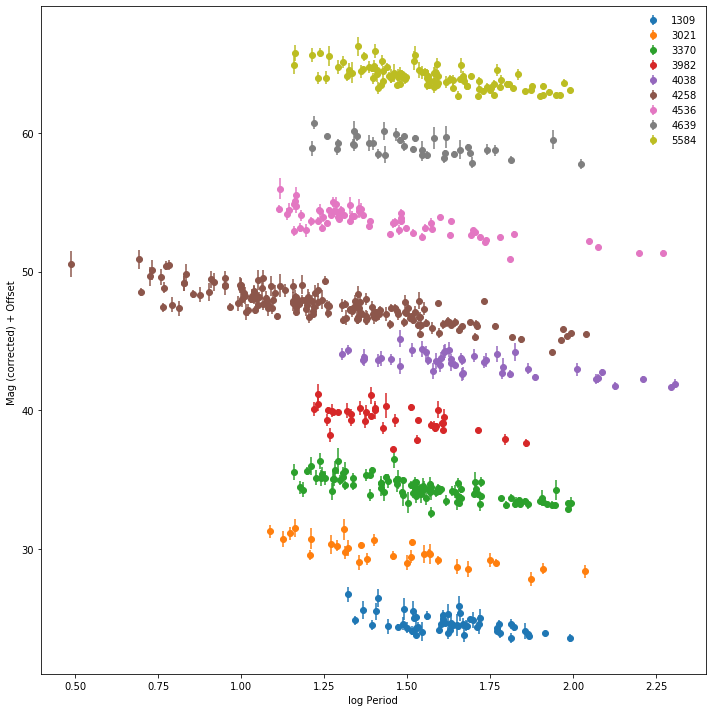

In [52]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()


# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


The originial equation (1) from Riess et al (2011), ignoring metallicity is:

$$m_{W,i,j} = (\mu_{0,i}-\mu_{0,4258}) + zp_{W, 4258} + b_{W} \times log(P_{i,j})$$
   
where $m_{W,i,j}$ and $P$ are observables and $zp_{W, 4258}$ and $b_{W}$ are nuisance parameters.
   
$\mu_{0,i}-\mu_{0,4258}$ is the different for each galaxy $i$, but same for each Cephids $j$ in the same galaxy, 

so we can view $\mu_{0,i}-\mu_{0,4258}$ as additional nuisance parameters, 

and there are as many of them as the numbers of individual galaxies in the data.

The likelihood is 

$$L \equiv \prod_{i=1}^{n}\prod_{j=1}^{m} p ( \{m_{W,i,j},P_{i,j}\} | M(zp_{W, 4258}, b_{W}, \mu_{0,i}-\mu_{0,4258}))$$

which can be written to be

$$L \equiv \prod_{i=1}^{n}\prod_{j=1}^{m} \frac{1}{\sqrt{2\pi}\sigma_{int}} exp(\frac{-(m_{W,i,j}-Model(P_{i,j}, zp_{W, 4258}, b_{W}, \mu_{0,i}-\mu_{0,4258}))^{2}}{2 \sigma_{int}})$$

and the log likelihood is 

$$ lnL = \Sigma_{i=1}^{n} \Sigma_{j=1}^{m} \frac{-(m_{W,i,j}-Model(P_{i,j}, zp_{W, 4258}, b_{W}, \mu_{0,i}-\mu_{0,4258}))^{2}}{2 \sigma_{int}^{2}}$$


# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

$zp_{W, 4258}$ is the intercept in y-axis and $b_{W}$ is the slope of the data of NGC4258, so the priors for them can be determined by looking at the NGC4258 data by eye. $zp_{W, 4258}$ is around 30, and $b_{W}$ is negative. I use normal distributions for priors for $zp_{W, 4258}$ and $b_{W}$, based on my inital fitting results with scipy minimize (see below for plots).

We have $n$ different $\mu_{0,i}-\mu_{0,4258}$ paramters for galaxy distances, where $n$ is the number of unique galaxies in the dataset. Since NGC4258 acts as the baseline, $\mu_{0,i}-\mu_{0,4258}$ is 0 for this galaxy and we reduce to $n-1$ paramters for galaxy distances. $\mu$ is the distance modulus and is related to the physical distance $d$ by $\mu = 5log_{10}(d)+5$. If we were to fit directly to $d$, I would choose a normal distribution as a prior, but since $\mu\sim log_10(d)$, I use a flat prior. The initial guess are also based on the scipy minimize fitting results. 

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [105]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner

def PLmodel(logP, zp, bw, ui0):
    return bw*logP + zp + ui0;

def chisq(params, host, mag, mag_err, logP):
    zp = params[0]
    bw = params[1]
    ui = params[2:]
    #print('data shape',len(args[0]))
    #host, mag, mag_err, logP = args
    
    host0 = np.unique(host)[np.where(np.unique(host)!=4258)]
    uij = np.zeros(len(host))
    for i in range(len(host)):
        if host[i]!=4258: 
            ## for NGC4258, the distance is fixed to 0, if host is not 4258, fit for the reddening-free distance.
            uij[i] = ui[np.where(host[i]==host0)[0][0]]
            
    chisq = np.sum((mag-PLmodel(logP, zp, bw, uij))**2/mag_err**2)
    return chisq;

def logLikelihood(params, host, mag, mag_err, logP):
    return -0.5*chisq(params, host, mag, mag_err, logP);


In [134]:
## read in data, try using the scipy optimization for initial guess
import scipy.optimize as so
hostid, mag, mag_err, period = np.loadtxt('../../data/03/R11ceph.dat',comments='#',usecols=(1,2,3,4)).T
logP0 = np.log10(period)

ngal = len(np.unique(hosts))
u0 = np.random.normal(loc=2.,size=ngal-1) 
zp0 = 30.
bw0 = -1.
p0 = [zp0,bw0]+list(u0)

res = so.minimize(chisq, p0, args=(hostid, mag, mag_err, logP0))
print(res.x)

[26.11796457 -2.85077635  3.09898636  2.88635353  2.66584114  2.23493851
  2.07466593  1.48356468  2.28567945  2.26186253]


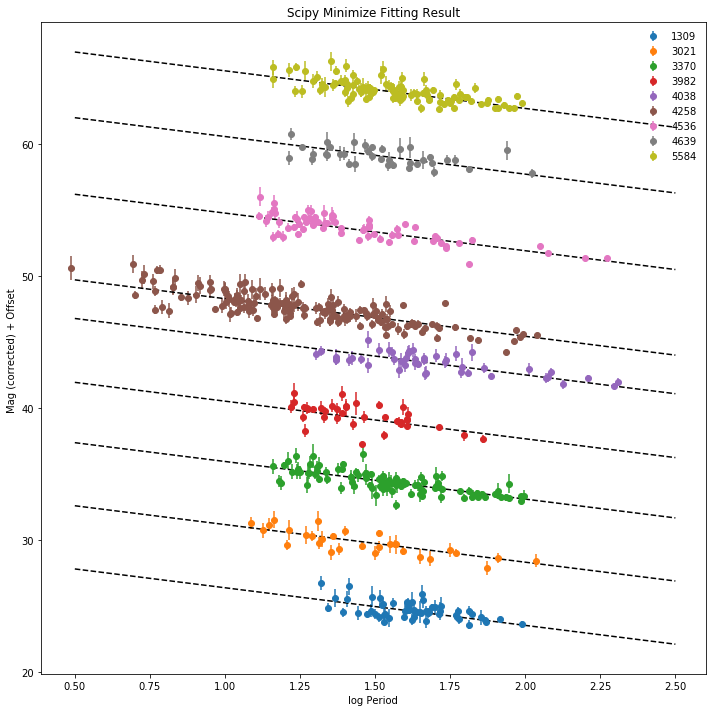

In [135]:
## plot the results from scipy minimize
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plot_logP = np.linspace(0.5,2.5,num=100)
host0 = np.unique(hostid)[np.where(np.unique(hostid)!=4258)]

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    if ID !='4258': 
        u0 = res.x[np.where(float(ID)==host0)[0]+2]
    else: 
        u0 = 0.
    ax.plot(plot_logP, (5*i)+PLmodel(plot_logP, res.x[0], res.x[1], u0),linestyle='--',color='k')
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
plt.title('Scipy Minimize Fitting Result')
fig.tight_layout()

In [136]:
## set up the priors and probability 
import scipy.stats as st
def logPrior(params):
    zp = params[0]
    bw = params[1]
    ui = params[2:]
    
    if  zp>0 and zp<100 and bw>-10 and bw<0 and np.max(ui)<6 and np.min(ui)>-1.:
    
        ## for the top-hat priors
        p_zp = np.log(st.norm.pdf(zp, loc=res.x[0], scale=res.x[0]/10.))
        p_bw = np.log(st.norm.pdf(bw, loc=res.x[1], scale=res.x[0]/10.))

        ## for ui using a normal distribution as prior
        prior = p_zp+p_bw
        #for i in range(len(ui)):
        #    p_ui = np.log(st.norm.pdf(ui[2+i], loc=2.5, scale=1.))
        #    prior = prior+p_ui
            
        return prior;
    else:
        return -np.inf;
    
def logProb(params, host, mag, mag_err, logP):
    #print (logPrior(params)+logLikelihood(params,*data))
    if logPrior(params)>-100.:
        return logPrior(params)+logLikelihood(params, host, mag, mag_err, logP);
    else:
        return -np.inf;

In [147]:
## run MCMC, using the scipy minimize results as prior

nwalkers = 100
ndim = len(p0) 

p0 = res.x 
pos = [p0 + np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, logProb, args=(hostid, mag, mag_err, logP0))
sampler.run_mcmc(pos, 500)

State([[26.17315476 -2.87952779  3.07172857  2.7728723   2.68203175  2.15005637
   2.14200265  1.4331622   2.32264207  2.24724821]
 [26.07411348 -2.80421214  3.01444239  2.87561083  2.6205201   2.25068672
   2.11123107  1.41624088  2.27870752  2.28425819]
 [26.10522671 -2.82858863  3.12804784  2.81481369  2.6687789   2.20549982
   2.0657956   1.49021513  2.25921269  2.17820845]
 [26.18821239 -2.88273632  3.08204744  2.93835775  2.65005445  2.11917046
   2.11053672  1.42939763  2.22923688  2.24183713]
 [26.05260783 -2.81674594  3.08667165  2.97090896  2.70401305  2.18825883
   2.05229257  1.49535739  2.30505956  2.29829794]
 [26.1440338  -2.88449744  3.1361478   2.82844064  2.67354686  2.28940791
   2.1964275   1.50979071  2.36306383  2.27922216]
 [26.10553352 -2.84408129  3.14006046  2.89250972  2.68247969  2.28307603
   2.10186417  1.44909966  2.29092905  2.28428066]
 [26.15732244 -2.87668303  3.14202074  3.02209729  2.67061479  2.23325482
   2.11973639  1.50714954  2.22673545  2.2536

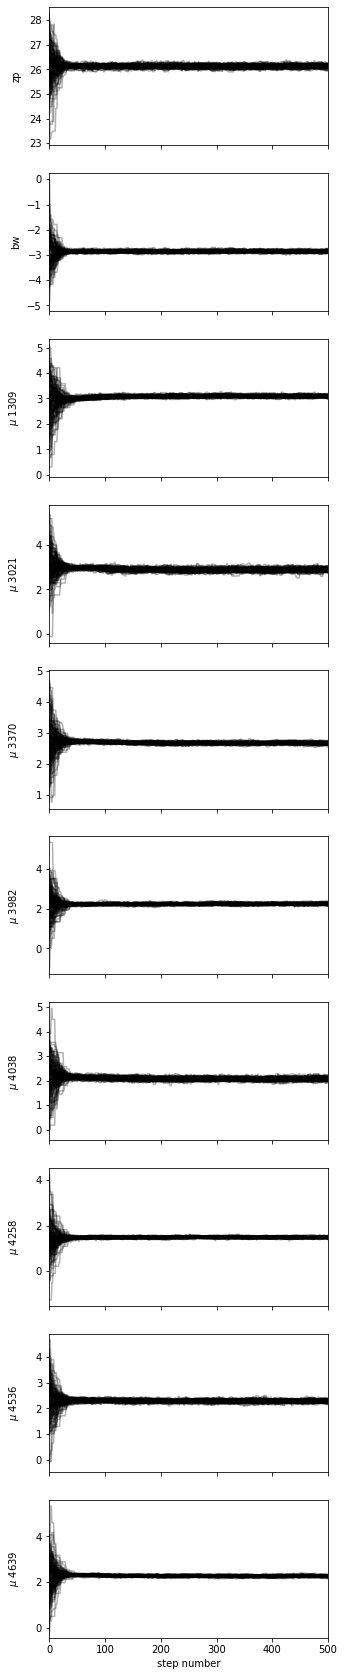

In [216]:
fig, axes = plt.subplots(ndim, figsize=(5,30), sharex=True)
samples = sampler.get_chain()
labels = ['zp', 'bw', r'$\mu$ 1309', r'$\mu$ 3021', r'$\mu$ 3370' ,r'$\mu$ 3982', r'$\mu$ 4038', r'$\mu$ 4258' ,r'$\mu$ 4536', r'$\mu$ 4639', r'$\mu$ 5584']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


zp Best fit: 26.12 -0.06 +0.07
bw Best fit: -2.85 -0.04 +0.04
$\mu$ 1309 Best fit: 3.09 -0.04 +0.04
$\mu$ 3021 Best fit: 2.89 -0.08 +0.08
$\mu$ 3370 Best fit: 2.67 -0.04 +0.03
$\mu$ 3982 Best fit: 2.23 -0.05 +0.05
$\mu$ 4038 Best fit: 2.08 -0.06 +0.06
$\mu$ 4258 Best fit: 1.48 -0.04 +0.03
$\mu$ 4536 Best fit: 2.29 -0.05 +0.06
$\mu$ 4639 Best fit: 2.26 -0.04 +0.04


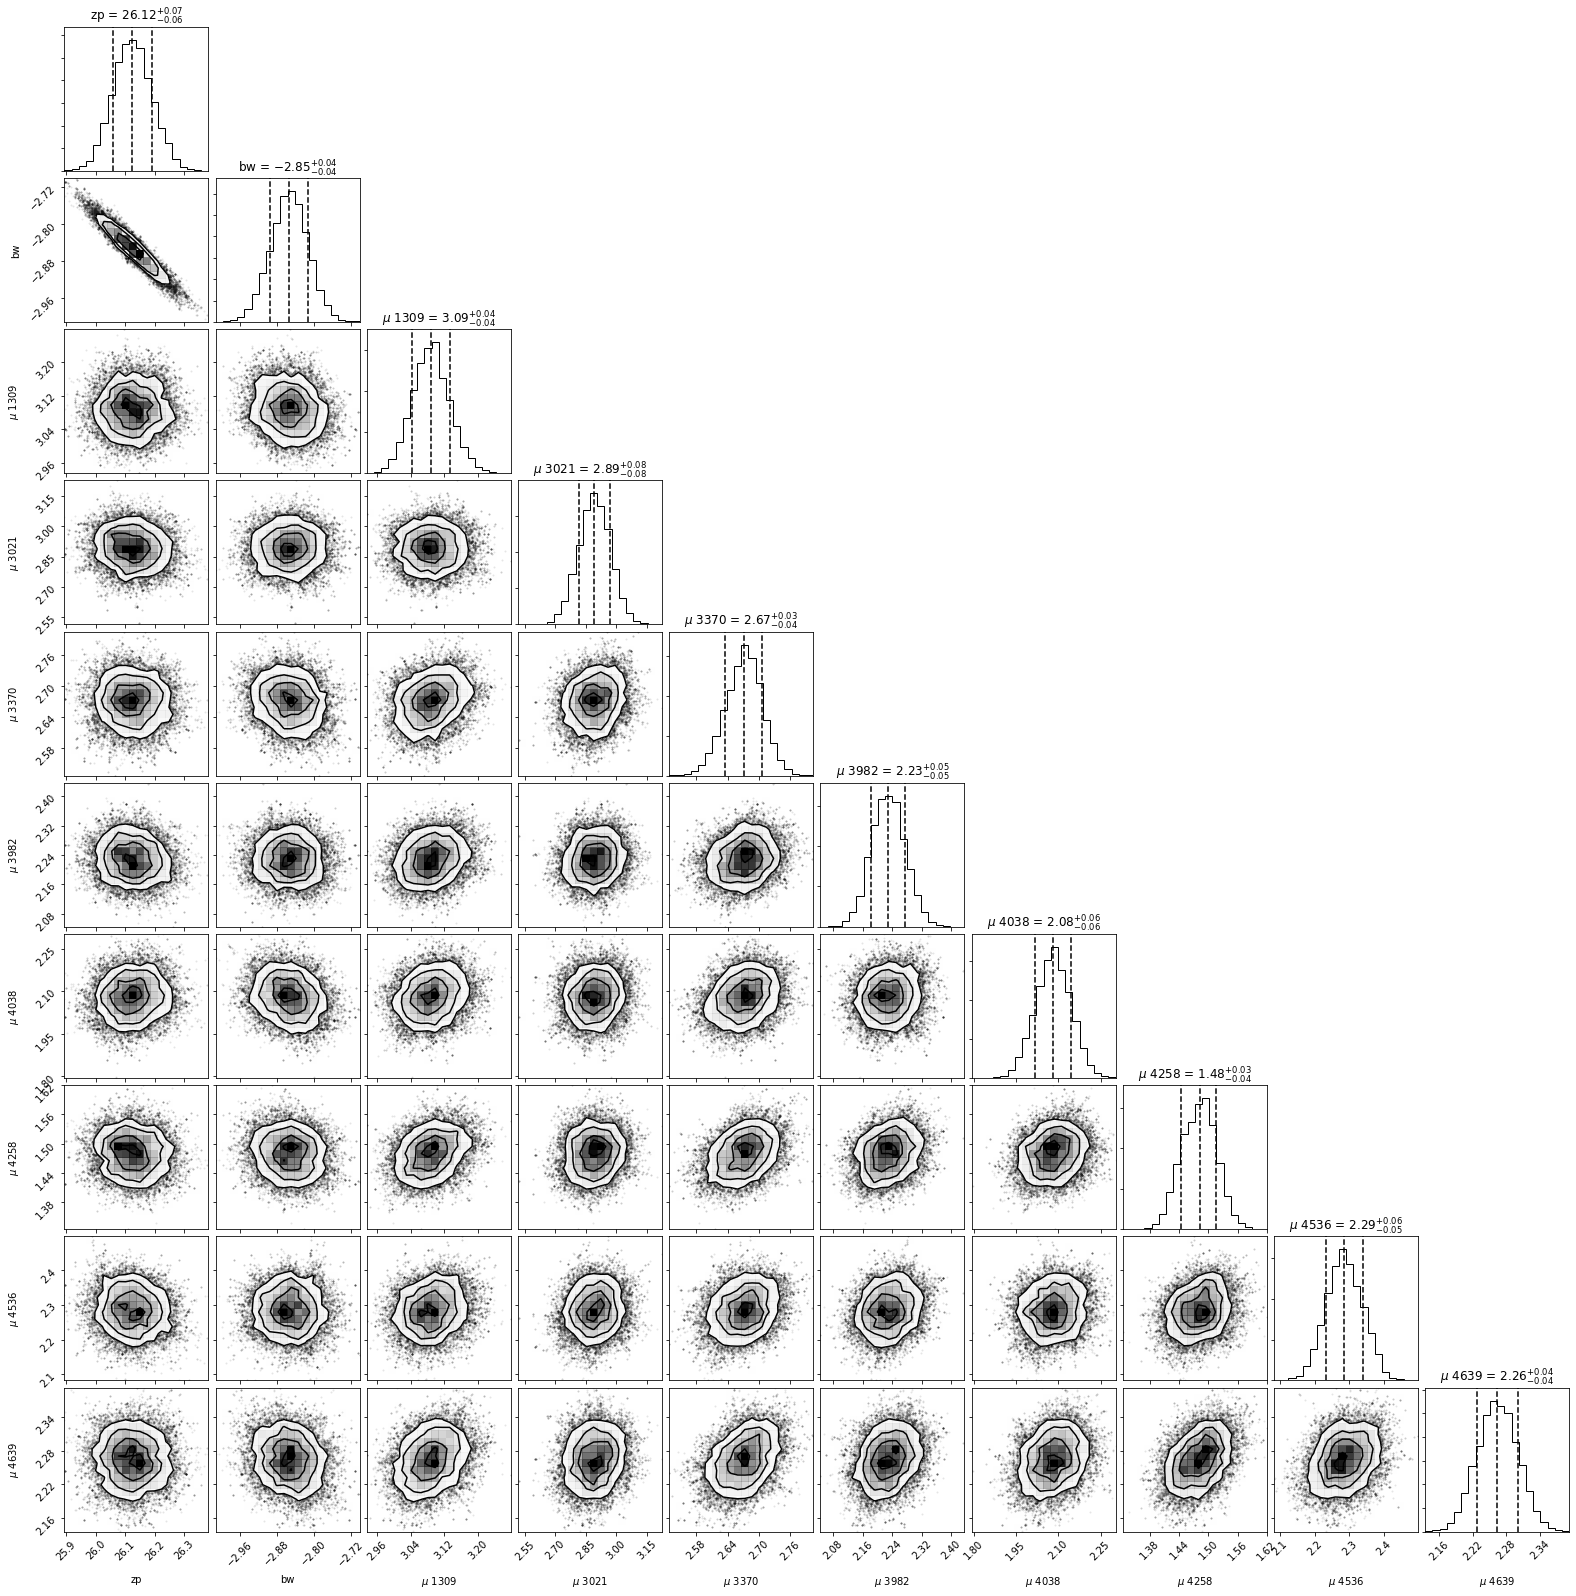

In [223]:
flat_samples = sampler.get_chain(discard=100, flat=True)
#print(flat_samples.shape)
fig = corner.corner(flat_samples,labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(labels[i], 'Best fit: {:.2f}'.format(mcmc[1]), '{:.2f}'.format(-q[0]), '+{:.2f}'.format(q[1]))

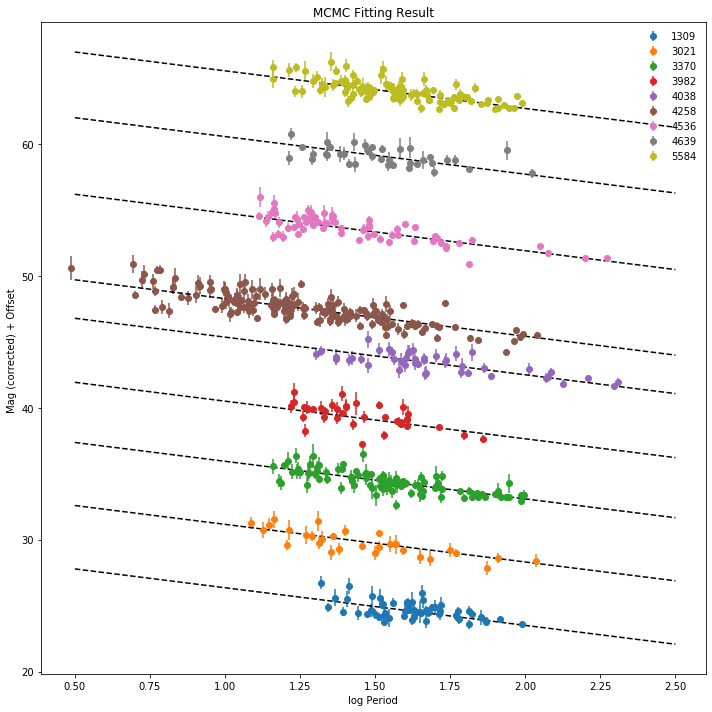

In [220]:
## plot the results from MCMC

best_fit = np.percentile(flat_samples, 50, axis=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plot_logP = np.linspace(0.5,2.5,num=100)
host0 = np.unique(hostid)[np.where(np.unique(hostid)!=4258)]

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    if ID !='4258': 
        u0 = best_fit[np.where(float(ID)==host0)[0]+2]
    else: 
        u0 = 0.
    ax.plot(plot_logP, (5*i)+PLmodel(plot_logP, best_fit[0], best_fit[1], u0),linestyle='--',color='k')
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
plt.title('MCMC Fitting Result')
fig.tight_layout()

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Equation (3) in Riess et al (2011):

$$ m_{v,i}^{0} = (\mu_{0,i}-\mu_{0,4258}) + m_{v,4258}^{0} $$

Equation (4) in Riess et al (2011):

$$ log(H_{0}) = \frac{(m_{v,4258}^{0}-\mu_{0,4258})+5a_{v}+25}{5} $$

From Equation (3), we have: 
    
$$ m_{v,4258}^{0} =  m_{v,i}^{0} - (\mu_{0,i}-\mu_{0,4258})  $$

And Equation (4) becomes

$$ log(H_{0}) = \frac{(m_{v,i}^{0} - (\mu_{0,i}-\mu_{0,4258})-\mu_{0,4258})+5a_{v}+25}{5} $$

where we can populate $m_{v,i}^{0}+5a_{v}$ from Riess et al (2011) Table 3, 

use the best-fit results for $(\mu_{0,i}-\mu_{0,4258})$, 

and $\mu_{0,4258}$ from Humphreys et al (2013), to estimate $H_{0}$. 

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [172]:
hostname = np.loadtxt('apj383673t3_ascii.txt',usecols=(0),skiprows=4,max_rows=8,dtype=str).T
m_vi = np.loadtxt('apj383673t3_ascii.txt',usecols=(4),skiprows=4,max_rows=8).T

hostname = np.array([x.split('n')[1] for x in hostname],dtype=int)
m_vi = m_vi[np.argsort(hostname)]

ui = best_fit[2:]

u4258 = 5.*np.log10(7.6e6)+5.

H0 = 10**((m_vi-ui-u4258+25.)/5.)

print(H0)

[0.71653644 0.75956761 0.78298057 0.73126691 0.76383312 0.71152455
 0.74155623 0.83393208]


In [209]:
print('Simple Mean','{:.3f}'.format(np.mean(H0)),', and standard deviation','{:.3f}'.format(np.std(H0)))
print('Simple Median','{:.3f}'.format(np.median(H0)),', 16 percentile','{:.3f} (-{:.3f})'.format(np.percentile(H0,16),np.median(H0)-np.percentile(H0,16)) ,',84 percentile','{:.3f} (+{:.3f})'.format(np.percentile(H0,84),np.percentile(H0,84)-np.median(H0)))


Simple Mean 0.755 , and standard deviation 0.037
Simple Median 0.751 , 16 percentile 0.718 (-0.032) ,84 percentile 0.781 (+0.030)


In [210]:
H0_clip, c1, c2 = st.sigmaclip(H0, low=2.0, high=2.0)

print('After 2-sigma clipping: Mean','{:.3f}'.format(np.mean(H0_clip)),', and standard deviation','{:.3f}'.format(np.std(H0_clip)))
print('After 2-sigma clipping: Median','{:.3f}'.format(np.median(H0_clip)),', 16 percentile','{:.3f} (-{:.3f})'.format(np.percentile(H0_clip,16),np.median(H0_clip)-np.percentile(H0_clip,16)) ,',84 percentile','{:.3f} (+{:.3f})'.format(np.percentile(H0_clip,84),np.percentile(H0_clip,84)-np.median(H0_clip)))


After 2-sigma clipping: Mean 0.744 , and standard deviation 0.024
After 2-sigma clipping: Median 0.742 , 16 percentile 0.716 (-0.025) ,84 percentile 0.765 (+0.023)


From QQ plot fitting: Median 0.748 , 1st quantile 0.718 (-0.030) ,3rd quantile 0.779 (+0.030)


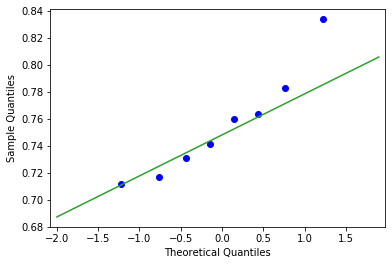

In [212]:
import statsmodels.api as sm

qq_25_75 = np.percentile(H0, [25, 75])
x_25 = st.norm.ppf(0.25)
x_75 = st.norm.ppf(0.75)
xvals = np.arange(-2, 2, 0.1)
def iqr_line(xvals):
    return ((xvals - x_25)/(x_75-x_25)) * (qq_25_75[1] - qq_25_75[0] ) + qq_25_75[0]
    
sm.qqplot(H0)
plt.plot(xvals, iqr_line(xvals), color='C2', label='IQR line')
print('From QQ plot fitting: Median','{:.3f}'.format(iqr_line(0.)),', 1st quantile','{:.3f} (-{:.3f})'.format(iqr_line(-1.),iqr_line(0.)-iqr_line(-1.)) ,',3rd quantile','{:.3f} (+{:.3f})'.format(iqr_line(1.),iqr_line(1.)-iqr_line(0.)))

